<a href="https://colab.research.google.com/github/HEsiyun/nlp-project-draft/blob/main/BitLinear_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Fri Nov 29 22:38:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0              42W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install bitnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.1/531.1 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.8/917.8 kB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.6/241.6 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Print out the model architecture
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Experiment with the Change using BitLinear on K, Q, dense layer of FF
from bitnet.bitlinear import BitLinear
import copy

# Step 1: Make a deep copy of the model to preserve the original model
new_model = copy.deepcopy(model)

# Step 2: Save original weights of the layers before modification
original_weights = {}
for idx, layer in enumerate(model.bert.encoder.layer):
    original_weights[f'layer_{idx}_query'] = layer.attention.self.query.weight.data.clone()
    original_weights[f'layer_{idx}_key'] = layer.attention.self.key.weight.data.clone()
    original_weights[f'layer_{idx}_dense'] = layer.intermediate.dense.weight.data.clone()

# Step 3: Modify the layers in the deep-copied model by replacing with BitLinear
for idx, layer in enumerate(new_model.bert.encoder.layer):
    # Replace query, key, and dense layers with BitLinear
    layer.attention.self.query = BitLinear(layer.attention.self.query.in_features, layer.attention.self.query.out_features)
    layer.attention.self.key = BitLinear(layer.attention.self.key.in_features, layer.attention.self.key.out_features)
    layer.intermediate.dense = BitLinear(layer.intermediate.dense.in_features, layer.intermediate.dense.out_features)

# Step 4: Compare the weights before and after modification
for idx, layer in enumerate(new_model.bert.encoder.layer):
    print(f"Layer {idx} - Weight Comparison:")

    # Get the weights of the modified BitLinear layers
    new_query_weight = layer.attention.self.query.weight.data
    new_key_weight = layer.attention.self.key.weight.data
    new_dense_weight = layer.intermediate.dense.weight.data

    # Calculate the absolute average of the original weights
    original_query_avg = original_weights[f'layer_{idx}_query'].abs().mean().item()
    original_key_avg = original_weights[f'layer_{idx}_key'].abs().mean().item()
    original_dense_avg = original_weights[f'layer_{idx}_dense'].abs().mean().item()

    # Print the absolute average of the original weights
    print(f"Absolute average of original query weights: {original_query_avg}")
    print(f"Absolute average of original key weights: {original_key_avg}")
    print(f"Absolute average of original dense weights: {original_dense_avg}")

    # Compare the original weights with the new weights (absolute difference)
    query_diff = (original_weights[f'layer_{idx}_query'] - new_query_weight).abs().mean().item()
    key_diff = (original_weights[f'layer_{idx}_key'] - new_key_weight).abs().mean().item()
    dense_diff = (original_weights[f'layer_{idx}_dense'] - new_dense_weight).abs().mean().item()

    # Print the average weight difference
    print(f"Average weight difference for query layer: {query_diff}")
    print(f"Average weight difference for key layer: {key_diff}")
    print(f"Average weight difference for dense layer: {dense_diff}")
    print("-" * 50)

Layer 0 - Weight Comparison:
Absolute average of original query weights: 0.027284588664770126
Absolute average of original key weights: 0.026742875576019287
Absolute average of original dense weights: 0.02639346569776535
Average weight difference for query layer: 0.032140228897333145
Average weight difference for key layer: 0.0316854752600193
Average weight difference for dense layer: 0.03139866515994072
--------------------------------------------------
Layer 1 - Weight Comparison:
Absolute average of original query weights: 0.030213356018066406
Absolute average of original key weights: 0.029993172734975815
Absolute average of original dense weights: 0.028449945151805878
Average weight difference for query layer: 0.03464411944150925
Average weight difference for key layer: 0.03446736931800842
Average weight difference for dense layer: 0.0331149622797966
--------------------------------------------------
Layer 2 - Weight Comparison:
Absolute average of original query weights: 0.0320123

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from torch.optim import AdamW
from tqdm import tqdm
import numpy as np
import torch.nn as nn
import random
# Import the function to replace linear layers
from bitnet.bitlinear import BitLinear

# Set the seed for Python's built-in random module
random.seed(42)

# Set the seed for NumPy
np.random.seed(42)

# Set the seed for PyTorch
torch.manual_seed(42)

# Set the seed for CUDA
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)  # situation when using multi-GPU.


# Load data from csv file
data = pd.read_csv('data.csv')

# Split the data
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

# Define a custom dataset
class ReviewDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        review = str(self.data.iloc[index, 1])
        label = self.data.iloc[index, 2]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', padding_side='right', truncation=True)
model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=2)

# Modify layers using BitLinear
for idx, layer in enumerate(model.bert.encoder.layer):
    # Replace query, key, and dense layers with BitLinear
    layer.attention.self.query = BitLinear(layer.attention.self.query.in_features, layer.attention.self.query.out_features)
    layer.attention.self.key = BitLinear(layer.attention.self.key.in_features, layer.attention.self.key.out_features)
    layer.intermediate.dense = BitLinear(layer.intermediate.dense.in_features, layer.intermediate.dense.out_features)

# Create data loaders
train_dataset = ReviewDataset(train_df, tokenizer, max_len=150)
val_dataset = ReviewDataset(val_df, tokenizer, max_len=150)
test_dataset = ReviewDataset(test_df, tokenizer, max_len=150)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

def train_epoch(model, data_loader, optimizer, device):
    model = model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch in tqdm(data_loader, desc="Training", unit="batch"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()
        _, preds = torch.max(logits, dim=1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(data_loader)
    avg_accuracy = correct_predictions / total_predictions

    return avg_loss, avg_accuracy

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).flatten()

            loss = loss_fn(logits, labels)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = correct_predictions.double() / n_examples
    avg_loss = np.mean(losses)
    report = classification_report(true_labels, predictions, zero_division=0)

    return accuracy, avg_loss, report

from collections import defaultdict

def train_epoch(model, data_loader, optimizer, device, batch_log_interval=100):
    model = model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch_idx, batch in enumerate(tqdm(data_loader, desc="Training", unit="batch")):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()
        _, preds = torch.max(logits, dim=1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)

        loss.backward()
        optimizer.step()

        # Print metrics every batch_log_interval batches
        if (batch_idx + 1) % batch_log_interval == 0:
            avg_loss = total_loss / (batch_idx + 1)
            avg_accuracy = correct_predictions / total_predictions
            print(f'Batch {batch_idx + 1}/{len(data_loader)} - Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}')

    avg_loss = total_loss / len(data_loader)
    avg_accuracy = correct_predictions / total_predictions

    return avg_loss, avg_accuracy

# Adjust the training loop for early stopping based on batches
history = defaultdict(list)
best_accuracy = 0
patience = 200  # Number of batches to wait for improvement
early_stopping_counter = 0

epochs = 3
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    print('-' * 10)

    train_loss, train_accuracy = train_epoch(model, train_loader, optimizer, device)

    val_accuracy, val_loss, val_report = eval_model(model, val_loader, loss_fn, device, len(val_loader.dataset))
    print(f'Validation loss: {val_loss} accuracy: {val_accuracy}')
    print(val_report)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_accuracy)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_accuracy)

    if val_accuracy > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_accuracy
        early_stopping_counter = 0
    else:
        early_stopping_counter += len(train_loader)  # Increment by number of batches

    if early_stopping_counter >= patience:
        print("Early stopping triggered")
        break

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Epoch 1/3
----------


Training:  18%|█▊        | 100/543 [00:38<02:43,  2.71batch/s]

Batch 100/543 - Loss: 0.5787, Accuracy: 0.6844


Training:  37%|███▋      | 200/543 [01:15<02:06,  2.71batch/s]

Batch 200/543 - Loss: 0.5335, Accuracy: 0.7245


Training:  55%|█████▌    | 300/543 [01:52<01:29,  2.71batch/s]

Batch 300/543 - Loss: 0.5017, Accuracy: 0.7481


Training:  74%|███████▎  | 400/543 [02:29<00:52,  2.71batch/s]

Batch 400/543 - Loss: 0.4843, Accuracy: 0.7607


Training:  92%|█████████▏| 500/543 [03:06<00:15,  2.70batch/s]

Batch 500/543 - Loss: 0.4720, Accuracy: 0.7700


Training: 100%|██████████| 543/543 [03:22<00:00,  2.68batch/s]


Validation loss: 0.40876279333058524 accuracy: 0.8134655291676274
              precision    recall  f1-score   support

           0       0.86      0.75      0.80      2185
           1       0.78      0.87      0.82      2152

    accuracy                           0.81      4337
   macro avg       0.82      0.81      0.81      4337
weighted avg       0.82      0.81      0.81      4337

Epoch 2/3
----------


Training:  18%|█▊        | 100/543 [00:36<02:43,  2.71batch/s]

Batch 100/543 - Loss: 0.3719, Accuracy: 0.8333


Training:  37%|███▋      | 200/543 [01:13<02:06,  2.71batch/s]

Batch 200/543 - Loss: 0.3766, Accuracy: 0.8312


Training:  55%|█████▌    | 300/543 [01:50<01:29,  2.71batch/s]

Batch 300/543 - Loss: 0.3752, Accuracy: 0.8318


Training:  74%|███████▎  | 400/543 [02:27<00:52,  2.71batch/s]

Batch 400/543 - Loss: 0.3712, Accuracy: 0.8352


Training:  92%|█████████▏| 500/543 [03:04<00:15,  2.70batch/s]

Batch 500/543 - Loss: 0.3709, Accuracy: 0.8349


Training: 100%|██████████| 543/543 [03:20<00:00,  2.71batch/s]


Validation loss: 0.39499036967754364 accuracy: 0.8275305510721698
              precision    recall  f1-score   support

           0       0.88      0.77      0.82      2185
           1       0.79      0.89      0.84      2152

    accuracy                           0.83      4337
   macro avg       0.83      0.83      0.83      4337
weighted avg       0.83      0.83      0.83      4337

Epoch 3/3
----------


Training:  18%|█▊        | 100/543 [00:36<02:43,  2.71batch/s]

Batch 100/543 - Loss: 0.3351, Accuracy: 0.8572


Training:  37%|███▋      | 200/543 [01:13<02:06,  2.71batch/s]

Batch 200/543 - Loss: 0.3329, Accuracy: 0.8591


Training:  55%|█████▌    | 300/543 [01:50<01:29,  2.71batch/s]

Batch 300/543 - Loss: 0.3282, Accuracy: 0.8593


Training:  74%|███████▎  | 400/543 [02:27<00:52,  2.70batch/s]

Batch 400/543 - Loss: 0.3279, Accuracy: 0.8601


Training:  92%|█████████▏| 500/543 [03:04<00:15,  2.71batch/s]

Batch 500/543 - Loss: 0.3264, Accuracy: 0.8608


Training: 100%|██████████| 543/543 [03:20<00:00,  2.71batch/s]


Validation loss: 0.37406309431090073 accuracy: 0.8392898316808854
              precision    recall  f1-score   support

           0       0.86      0.81      0.84      2185
           1       0.82      0.87      0.84      2152

    accuracy                           0.84      4337
   macro avg       0.84      0.84      0.84      4337
weighted avg       0.84      0.84      0.84      4337



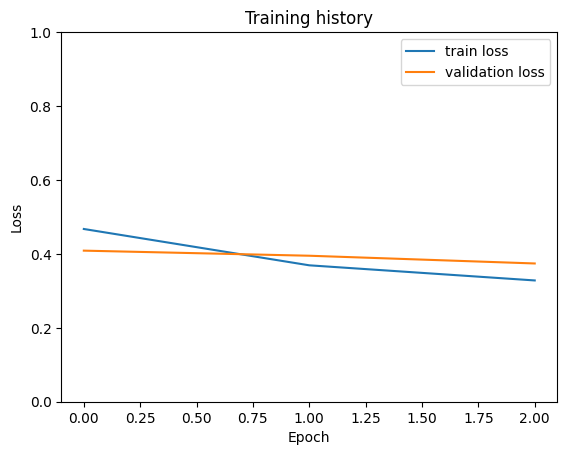

In [ ]:
import matplotlib.pyplot as plt
# Clear any previous plot if there is one
plt.clf()

if isinstance(history['train_loss'], list):
    history['train_loss'] = torch.tensor(history['train_loss'])

if isinstance(history['val_loss'], list):
    history['val_loss'] = torch.tensor(history['val_loss'])

train_loss = history['train_loss'].cpu().numpy()

val_loss = history['val_loss'].cpu().numpy()

plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='validation loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

plt.show()

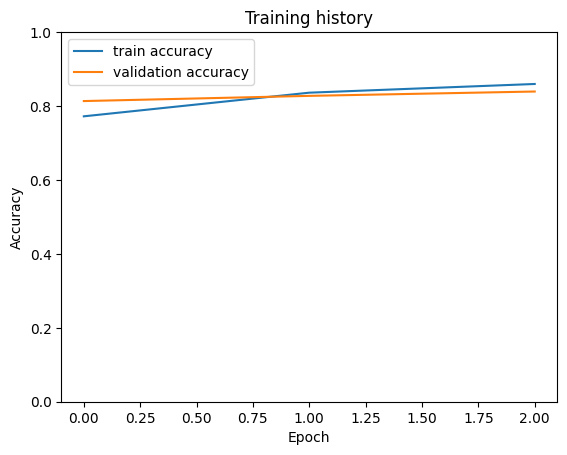

In [ ]:
import matplotlib.pyplot as plt
# Clear any previous plot if there is one
plt.clf()

if isinstance(history['train_acc'], list):
    history['train_acc'] = torch.tensor(history['train_acc'])

if isinstance(history['val_acc'], list):
    history['val_acc'] = torch.tensor(history['val_acc'])

train_acc = history['train_acc'].cpu().numpy()
val_acc = history['val_acc'].cpu().numpy()

# draw the plot
plt.plot(train_acc, label='train accuracy')
plt.plot(val_acc, label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

plt.show()

In [ ]:
# Get the accuracy score on test dataset
test_acc, _, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(test_df)
)

test_acc.item()

0.8358312197371456

In [ ]:
import torch.nn.functional as F

def get_predictions(model, data_loader, device):
    model = model.eval()  # Set the model to evaluation mode

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():  # Disable gradient calculation
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Get predicted class by taking the class with the highest logit value
            _, preds = torch.max(logits, dim=1)

            # Calculate probabilities using softmax
            probs = F.softmax(logits, dim=1)

            # Collect results
            review_texts.extend(texts)
            predictions.extend(preds.cpu().numpy())
            prediction_probs.extend(probs.cpu().numpy())
            real_values.extend(labels.cpu().numpy())

    return review_texts, predictions, prediction_probs, real_values

# Use the function to get predictions
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader, device)

Test loss: 0.36388691186028366 accuracy: 0.8358312197371456
              precision    recall  f1-score   support

           0       0.86      0.81      0.83      2204
           1       0.81      0.87      0.84      2133

    accuracy                           0.84      4337
   macro avg       0.84      0.84      0.84      4337
weighted avg       0.84      0.84      0.84      4337



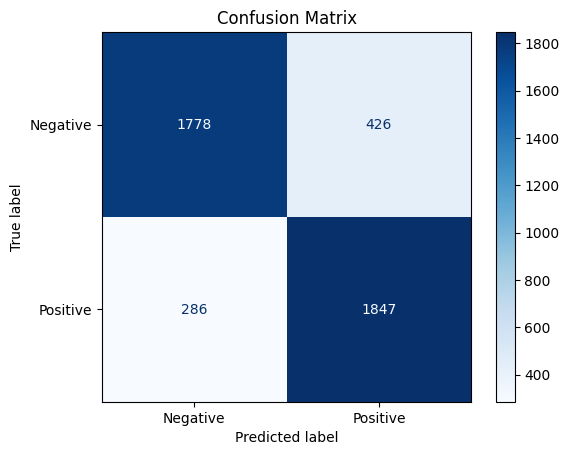

In [ ]:
# Generate the confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(true_labels, predictions, class_names):
    cm = confusion_matrix(true_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

test_accuracy, test_loss, test_report = eval_model(model, test_data_loader, loss_fn, device, len(test_data_loader.dataset))
print(f'Test loss: {test_loss} accuracy: {test_accuracy}')
print(test_report)

#  binary classification with labels 0 and 1
class_names = ['Negative', 'Positive']

plot_confusion_matrix(y_test, y_pred, class_names)


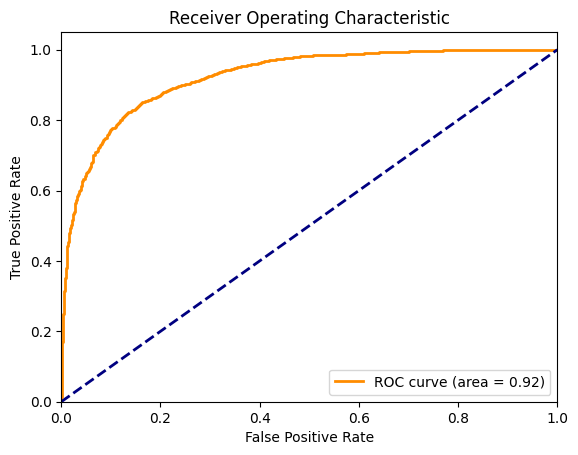

In [ ]:
from sklearn.metrics import roc_curve, auc
y_pred_probs_positive = [prob[1] for prob in y_pred_probs]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs_positive)

# Calculate AUC
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()